# Examples 2.1 and 2.2 
From Parameter Estimation and Inverse Problems, 3rd edition, 2018  
by R. Aster, B. Borchers, C. Thurber  
ported to Python by J. MacCarthy

In [ ]:
%reset -f

In [19]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# show the figures in the Jupyter notebook
%matplotlib inline

Make sure we have a clean environment.

In [20]:
np.random.seed(0)

Load precomputed data.

In [ ]:
matdata = loadmat('data1.mat', squeeze_me=True)

In [30]:
t, y, sigma = matdata['data1'].T
N = len(t)

Display t, y, sigma.

In [117]:
t, y, sigma

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 array([ 109.3827,  187.5385,  267.5319,  331.8753,  386.0535,  428.4271,
         452.1644,  498.1461,  512.3499,  512.9753]),
 array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.]))

Build the parabolic system matrix.

In [86]:
G = np.array([np.ones_like(t), t, -0.5 * t**2]).T

Apply the weighting.  
*Note*: in the second operation, `sigma` is [broadcast](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) to match the dimensions of `G`.

In [87]:
yw = y / sigma
Gw = G / sigma[:, np.newaxis]

Solve for the least-squares solution.

In [114]:
m = np.linalg.inv(Gw.T @ Gw) @ (Gw.T @ yw)

Get the covariance matrix

In [111]:
ginv = np.linalg.inv(Gw.T @ Gw) @ Gw.T
covm = ginv @ ginv.T
print(covm)

[[ 88.53333333 -33.6         -5.33333333]
 [-33.6         15.44242424   2.66666667]
 [ -5.33333333   2.66666667   0.48484848]]


Get the 1.96-sigma (95%) conf intervals.

In [121]:
del_ = 1.96 * np.sqrt(np.diag(covm))

print('95% parameter confidence intervals (m-, mest, m+)')
m - del_, m, m + del_

95% parameter confidence intervals (m-, mest, m+)


(array([ -2.02465374,  89.26547595,   8.04276678]),
 array([ 16.41740833,  96.96765856,   9.40753561]),
 array([  34.8594704 ,  104.66984117,   10.77230443]))

Because there are 3 parameters to estimate, we have `N-3` degrees of freedom.

In [122]:
dof = N - 3
chi2_ = np.linalg.norm((y - G @ m) / sigma)**2
print("The Chi-square misfit for {} degrees of freedom is {}.".format(dof, chi2_))

The Chi-square misfit for 7 degrees of freedom is 4.204836261879505.


Find the p-value for this data set.

In [123]:
from scipy.stats import chi2

p = 1 - chi2.cdf(chi2_, dof)

print('chi-square p-value: {}'.format(p))

chi-square p-value: 0.7559051789602904


Find the parameter correlations.

In [157]:
s = np.sqrt(np.diag(covm))
r = covm / (s[:, np.newaxis] * s.T)
print('correlation matrix')
r

correlation matrix


array([[ 1.        , -0.90871591, -0.81403354],
       [-0.90871591,  1.        ,  0.97455863],
       [-0.81403354,  0.97455863,  1.        ]])

Plot the data and model predicted data.

Displaying Data and Model Fit (fig 1)


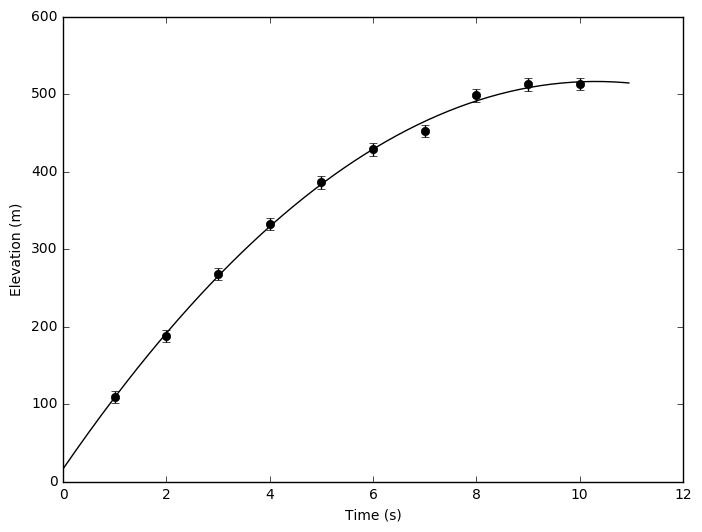

In [175]:
xx = np.arange(t.min() - 1, t.max() + 1, step=0.05)
mm = m[0] + m[1] * xx - 0.5 * m[2] * xx**2

plt.figure(1, figsize=(8,6))
plt.clf()
plt.plot(xx, mm, 'k')
plt.errorbar(t, y, yerr=sigma, fmt='ko')
plt.xlabel('Time (s)')
plt.ylabel('Elevation (m)')

print('Displaying Data and Model Fit (fig 1)')
plt.savefig('c2fparabfig.eps')

### Output covm and the eigenvalues/eigenvectors of covm.

Covariance matrix for fitted parameters.

In [177]:
covm

array([[ 88.53333333, -33.6       ,  -5.33333333],
       [-33.6       ,  15.44242424,   2.66666667],
       [ -5.33333333,   2.66666667,   0.48484848]])

Eigenvalues/eigenvectors of the covariance matrix  
*Note: eigenvalues/vectors aren't necessarily in the same order as in MATLAB*

In [189]:
lam, u = np.linalg.eig(np.linalg.inv(covm))

95% confidence ellipsoid semiaxis lengths

In [ ]:
semi_axes = np.sqrt(chi2.ppf(0.95, 3) * (1 / np.diag(lam)))

95% confidence ellipsoid semiaxes

In [ ]:
semi_axes[0] * u[:, 0], semi_axes[1] * u[:, 1], semi_axes[2] * u[:, 2]

## Monte Carlo Section

In [ ]:
y0 = G * m

In [ ]:
mmc = np.empty((1000, len(sigma)))
chimc = np.empty(1000)

for nreal in range(1000):
  # Generate a trial data set of perturbed, weighted data
  ytrial = y0 + sigma * np.random.randn(N)
  ywtrial = ytrial / sigma
  mmc[nreal] = np.linalg.solve(Gw, ywtrial)
  chimc[nreal] = np.linalg.norm((np.dot(G, mmc[nreal]) - ytrial) / sigma)**2

Plot the histogram of chi squared values
Displaying 1000 Monte-Carlo Chi-square Values (fig 2)

In [ ]:
plt.figure(2)
plt.clf()
plt.hist(chimc, 30)
plt.ylabel('N')
plt.xlabel('\chi^2')

Plot the histograms of the model parameters
Displaying Monte-Carlo Model Histograms (fig 3)

In [ ]:
plt.figure(3)
plt.clf()

plt.subplot(1,3,1)
plt.hist(mmc[:,0])
plt.title('m_1 (m)')

plt.subplot(1,3,2)
plt.hist(mmc[:,1])
plt.title('m_2 (m/s)')

plt.subplot(1,3,3)
plt.hist(mmc[:,2])
plt.title('m_3 (m/s^2)')

Plot the realizations of each pair of model parameters with the other
Displaying Projections of 1000 Monte-Carlo models (fig 4)

In [ ]:
plt.figure(4)
plt.clf()

plt.subplot(1,3,1)
plt.plot(mmc[:,0], mmc[:,1], 'k*')
plt.xlabel('m_1 (m)')
plt.ylabel('m_2 (m/s)')

plt.subplot(1,3,2)
plt.plot(mmc[:,0], mmc[:,2], 'k*')
plt.xlabel('m_1 (m)')
plt.ylabel('m_3 (m/s^2)')

plt.subplot(1,3,3)
plt.plot(mmc[:,1], mmc[:,2], 'k*')
plt.xlabel('m_2 (m/s)')
plt.ylabel('m_3 (m/^2)')

Plot the 95% error ellipses for each pair of parameters
Note that because we're doing pairs of parameters there are 2
degrees of freedom in the Chi-square here, rather than 3.

In [ ]:
# generate a vector of angles from 0 to 2*pi
theta = np.arange(0, 2*np.pi, 0.01)
delta = np.sqrt(chi2.ppf(0.95, 2))

# the radii in each direction from the center
r = np.zeros((len(theta), 2))

In [ ]:
plt.figure(5)
plt.clf()

# compute the data for the m1, m2 ellipsoid.
C = covm[0:2, 0:2]
u, lam = np.eig(np.inv(C))

# calculate the x component of the ellipsoid for all angles
r[0] = (delta / np.sqrt(lam[0,0])) * u[0,0] * np.cos(theta)
       + (delta / np.sqrt(lam[1,1])) * u[0,1] * np.sin(theta)

# calculate the y component of the ellipsoid for all angles
r[1] = (delta / np.sqrt(lam[0,0])) * u[1,0] * np.cos(theta)
       + (delta / np.sqrt(lam[1,1])) * u[1,1] * np.sin(theta)

# plot the data for the m1, m2 ellipsoid
plt.subplot(1,3,1)
plt.plot(m[1] + r[:,0], m[1] + r[:,1], 'k')
plt.fill(m[0] + r[:,0], m[1] + r[:,1], 'k')
plt.axis([-50 50 85 110])
plt.xlabel('m_1 (m)')
plt.ylabel('m_2 (m/s)')

# compute the data for the m1, m3 ellipsoid.
C = covm[[0,2],[0,2]]
u, lam = np.eig(np.inv(C))
deltachisq = chi2.ppf(0.95, 2)
delta = np.sqrt(deltachisq)
# calculate the x component of the ellipsoid for all angles
r[:,0] = (delta / np.sqrt(lam[0,0])) * u[0,0] * np.cos(theta)
         + (delta / np.sqrt(lam[1,1])) * u[0,1] * np.sin(theta)
# calculate the y component of the ellipsoid for all angles
r[:,1] = (delta / np.sqrt(lam[0,0])) * u[1,0] * np.cos(theta)
         + (delta / np.sqrt(lam[1,1])) * u[1,1] * np.sin(theta)

# plot the data for the m1, m3 ellipsoid
plt.subplot(1,3,2)
plt.plot(m[0] + r[:,0], m[2] + r[:,1], 'k')
plt.fill(m[0] + r[:,0], m[2] + r[:,1], 'k')
plt.axis([-50 50 7 12])
plt.xlabel('m_1 (m)')
plt.ylabel('m_3 (m/s^2)')

# compute the data for the m2, m3 ellipsoid.
C = covm[[1,2], [1,2]]
u, lam = np.eig(np.inv(C))
deltachisq = chi2.ppf(0.95, 2)
delta = np.sqrt(deltachisq)
# calculate the x component of the ellipsoid for all angles
r[:,0] = (delta / np.sqrt(lam[0,0])) * u[0,0] * np.cos(theta)
         + (delta / np.sqrt(lam[1,1])) * u[0,1] * np.sin(theta)
# calculate the y component of the ellipsoid for all angles
r[:,1] = (delta / np.sqrt(lam[0,0])) * u[1,0] * np.cos(theta)
         + (delta / np.sqrt(lam[1,1])) * u[1,1] * np.sin(theta)

# plot the data for the m2, m3 ellipsoid
plt.subplot(1,3,3)
plt.plot(m[1] + r[:,0], m[2] + r[:,1], 'k')
plt.fill(m[1] + r[:,0], m[2] + r[:,1], 'k')
plt.axis([80 120 7 12])
plt.xlabel('m_2 (m/s)')
plt.ylabel('m_3 (m/s^2)')
plt.savefig('c2fellipseproj.eps')

print('Displaying 95% Confidence Ellipse Projections (fig 5)')